In [8]:
import igraph as g
import constants
import json
import math

In [9]:
graph = g.Graph().Read("out.graph",format="graphml")

listComponentVertices = [[[306, 206], [313, 221], [324, 206], [325, 222], [340, 205], [340, 221]], [[405, 340], [407, 330], [417, 330], [419, 343], [427, 331], [431, 340]], [[248, 269], [248, 290], [248, 303], [260, 268], [260, 306], [261, 290]], [[532, 194], [536, 209], [547, 193], [549, 209], [564, 206], [565, 193]], [[399, 226], [401, 183], [413, 231], [417, 179], [427, 183], [430, 225]], [[320, 366], [324, 319], [332, 316], [332, 371], [342, 367], [343, 319]], [[165, 332], [169, 378], [173, 327], [179, 379], [186, 325], [190, 373]], [[312, 49], [314, 109], [320, 110], [325, 44], [330, 45], [334, 104]], [[329, 404], [335, 402], [345, 405]], [[536, 292], [551, 290], [568, 292]], [[60, 425], [84, 421], [110, 425]], [[410, 392], [417, 391], [434, 393]], [[168, 417], [182, 412], [205, 410]]]
classifications = ['inductor', 'inductor', 'inductor', 'inductor', 'inductor', 'ground', 'inductor', 'ground', 'inductor', 'inductor', 'ground', 'ground', 'ground', 'ground', 'ground']
#buildingPartNotes =[[(405, 340), (407, 330), (417, 330), (419, 343), (427, 331), (431, 340)]]
#classifications = ["resistor"]

#for i in range(0, len(buildingPartNotes)):
#    for j in range(0, len(buildingPartNotes[i])):
#        buildingPartNotes[i][j] = tuple(buildingPartNotes[i][j])


layout = graph.layout("large_graph")
#g.plot(graph, layout=layout,bbox = (1000,1000))

## Make a singel Node out of the Components

In [ ]:
def replaceComponent(graph,component,compType):
    intersections = component.verticesWithColor(constants.INTERSECTION_COLOR)

    for intersection in intersections:
        graph.getVertex(intersection.id).color = constants.CONNECTION_NODE_COLOR


for i in range(0, len(listComponentVertices)):
    graph = replaceComponent(graph,listComponentVertices[i],classifications[i])
    

igraph.Vertex(<igraph.Graph object at 0x000002AB45CAD5E0>, 0, {'name': '[417, 330]', 'color': 'white', 'label': '[417, 330]', 'id': 'n0', 'coordinate': (417, 330)})


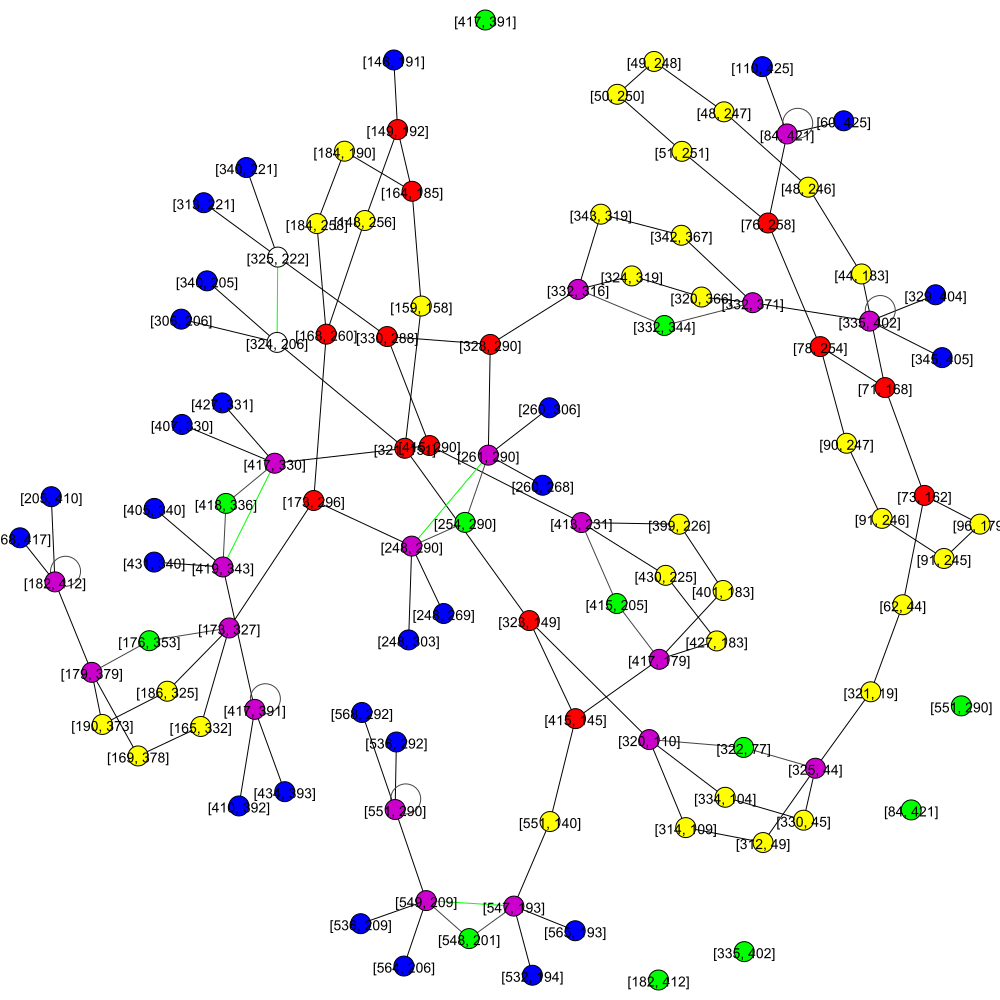

In [10]:
def getVertexByColor(graph,nodes,color):
    intersections = []
    for node in nodes:
        vertex = graph.vs.find(coordinate=node)
        if vertex["color"] == color:
            intersections.append(vertex)
    return intersections

def getNeighborVertices(graph,vertex):
    neighbors = graph.neighbors(vertex)
    neighbors = list(map(lambda id: graph.vs.find(id),neighbors))
    return neighbors

#def nameToCoorods(graph):
#    for vertex in graph.vs:
#        vertex["coordinate"] = tuple(json.loads(vertex["name"]))
#    return graph

# componentVertices -> All the Vertecies that represent a component
# compType -> describing the type of the component: resistor, cap...
# connectionDic -> A Dic with the vertices, representing the "component" connections. The key is the order of the Connection (ordertd Top left to bottom right)
def replaceComponent(graph,componentVertices,compType):#,connectionDic):


    connections = getVertexByColor(graph,componentVertices,constants.INTERSECTION_COLOR) + getVertexByColor(graph,componentVertices,constants.OTHER_NODE_COLOR)

    for con in connections:
        con["color"] = constants.CONNECTION_NODE_COLOR




    # Calc center of connections
    coordinates = list(map(lambda x: x["coordinate"],connections))
    xCoords = list(zip(*coordinates))[0]
    yCoords = list(zip(*coordinates))[1]
    center = [round(sum(xCoords)/len(xCoords)),round(sum(yCoords)/len(yCoords))]

    graph.add_vertex(name=str(center),label=str(center),componentType=compType,coordinate=tuple(center),color=constants.COMPONENT_NODE_COLOR)
    centerVertex = graph.vs.find(coordinate = tuple(center))

    #create connections
    for con in connections:
        graph.add_edge(con,centerVertex)



    ##replace every connection with the real neighbour vertex
    #for key in sorted(connectionDic):
    #    neighbors = list(map(lambda vertex:vertex["coordinate"],getNeighborVertices(graph,connectionDic[key])))
    #    for neighbor in neighbors:
    #        if not neighbor in componentVertices:
    #            vertex = graph.vs.find(coordinate=neighbor)
    #            connectionDic[key] = vertex
    #            break
#
    #connectionCooordinates = {}
    #for key in sorted(connectionDic):
    #    connectionCooordinates[key] = connectionDic[key]["coordinate"]
    ##create new component vertex
    #graph.add_vertex(name=str(center),label=str(center),componentType=compType,coordinate=tuple(center),connectionMap=connectionCooordinates,color=constants.COMPONENT_NODE_COLOR)
    #centerVertex = graph.vs.find(coordinate = tuple(center))
#
    ##create connections
    #for vertex in connectionDic.values():
    #    graph.add_edge(vertex,centerVertex)
#
    ## removing all componentVertices
    #for componentVertex in componentVertices:
    #    graph.delete_vertices([graph.vs.find(coordinate=componentVertex)])
    #
#

    return graph

# componentVertices -> All the Vertecies that represent a component
# Gets all the connection Points to a Component and orders them top left to bottom right
def generateConnectionDic(graph,componentVertices):
    #Get connection Points
    connections = getVertexByColor(graph,componentVertices,constants.INTERSECTION_COLOR) + getVertexByColor(graph,componentVertices,constants.OTHER_NODE_COLOR)
    
    #Order by top left to bottom right
    #Group Connections whose Y values differ in only 20 Pixels
    dic = {}
    for connection in connections:
        key = math.floor(connection["coordinate"][1]/40)*40
        if key in dic:
            dic[key].append(connection)
        else:
            dic[key] = [connection]

    # now sort every category left to right
    # and recombine them into a list
    out = []
    for key in sorted(dic):
        out += sorted(dic[key],key=lambda x:x["coordinate"][0])

    return dict(zip(range(0,len(out)),out))

# TO CHANGE
#graph = nameToCoorods(graph)
print(graph.vs[0])

#for every component
for i in range(1, len(buildingPartNotes)):
    #b = buildingPartNotes[i]
    #connectionDic = generateConnectionDic(graph, b)
    #graph = replaceComponent(graph, b, classifications[i], connectionDic) 
    graph = replaceComponent(graph, buildingPartNotes[i], classifications[i])             #constants.RESISTOR_TYPE

layout = graph.layout("fr")
g.plot(graph, layout=layout,bbox = (1000,1000))

## Now scale the whole Cuircit to fit the LT-Spice Cuircit

* Get the avarage Resistor Size
* Convert the cooridantes in the Cuircit to the Reisistorsize unit (1 Unit = Size of a Resistor)

In [11]:
#STEP 1: Avare Resistor Lenght
# get all Resistors
resistors = graph.vs.select(componentType=constants.RESISTOR_TYPE)
# for every Resistor calc lenght


# noch falsch

def calcComponentLenght(componentVertex):
    xCoords,yCoords = zip(*componentVertex["connectionMap"].values())
    xLenght = max(xCoords) - min(xCoords)
    yLenght = max(yCoords) - min(yCoords)
    if xLenght > yLenght:
        return xLenght
    return yLenght

avrResistorLenght = sum(map(calcComponentLenght,resistors))/len(resistors)


print("One Reistor Unit= " + str(avrResistorLenght))
#STEP 2: Convert all Coordinates to ResistorUnits

ZeroDivisionError: division by zero

In [ ]:
def getResistorPoints(midPoint, rotation):
    con1 = (0,0)
    con2 = (0,0)
    res = (0,0)

    if rotation == 0:
        res = (round((midPoint[0]-56)/16)*16, round((midPoint[1]+56)/16)*16)
        con1 = (res[0]+16, res[1]+16)
        con2 = (res[0]+16, res[1]+96)
    elif rotation == 90:
        res = (round((midPoint[0]+56)/16)*16, round((midPoint[1]-16)/16)*16)
        con1 = (res[0]-96, res[1]+16)
        con2 = (res[0]-16, res[1]+16)

    return [res, con1, con2]


In [ ]:
ltspice = open("circuit.asc", "w")
ltspice.write("Version 4\n")
ltspice.write("SHEET 1 880 680\n")

resistors = graph.vs.select(componentType=constants.RESISTOR_TYPE)

for res in resistors:
    print(res["coordinate"])
    points = getResistorPoints(res["coordinate"], 90)
    ltspice.write("WIRE {x1} {y1} {x2} {y2}\n".format(x1=points[1][0], y1=points[1][1], x2=points[1][0]-32, y2=points[1][1]))
    ltspice.write("WIRE {x1} {y1} {x2} {y2}\n".format(x1=points[2][0], y1=points[2][1], x2=points[2][0]+32, y2=points[2][1]))
    ltspice.write("SYMBOL Misc\\EuropeanResistor {x} {y} R90\n".format(x=points[0][0], y=points[0][1]))
    ltspice.write("WINDOW 0 5 56 VBottom 2\n")
    ltspice.write("WINDOW 3 27 56 VTop 2\n")
    ltspice.write("SYMATTR InstName R1\n")

ltspice.close()

In [ ]:
#ltspice = open("circuit.asc", "w")
#ltspice.write("Version 4\n")
#ltspice.write("SHEET 1 880 680\n")
#ltspice.write("WIRE 160 96 80 96\n")
#ltspice.write("WIRE 304 96 240 96\n")
#ltspice.write("SYMBOL Misc\\EuropeanResistor 256 80 R90\n")
#ltspice.write("WINDOW 0 5 56 VBottom 2\n")
#ltspice.write("WINDOW 3 27 56 VTop 2\n")
#ltspice.write("SYMATTR InstName R1\n")
#ltspice.close()